In [1]:
%matplotlib notebook

In [2]:
import autograd.numpy as np
import matplotlib.pyplot as plt
import celerite
from celerite import terms
import emcee
import corner
from scipy import signal
from astropy.io import fits

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:72: UserWarning: h5py is running against HDF5 1.10.2 when it was built against 1.10.3, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)


<IPython.core.display.Javascript object>


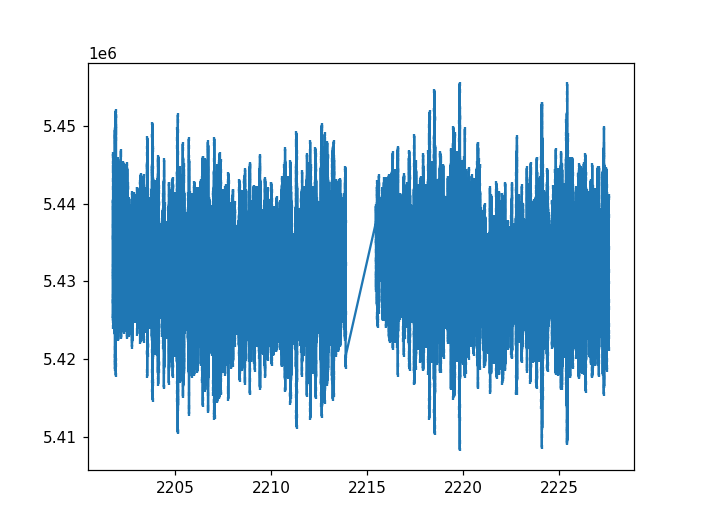

In [3]:
### TESS 2020_2021 data import ###
hdul = fits.open("tess2020351194500-s0033-0000000270577175-0203-s_lc.fits")

#SAP_FLUX, PDCSAP_FLUX, SAP_BKG, QUALITY
data = hdul[1].data
time = data['TIME']
flux = data['SAP_FLUX']
flux_error = data['SAP_FLUX_ERR']
index = np.argwhere((time<2240) & (~np.isnan(flux)) & (data["QUALITY"] == 0))
time = np.ndarray.flatten(time[index])
flux = np.ndarray.flatten(flux[index])
flux_error = np.ndarray.flatten(flux_error[index])
plt.figure()
plt.errorbar(time,flux,yerr=flux_error,markersize=1,capsize=0,fmt="-")
plt.show()

In [9]:
### GP Model ###
bounds = dict(log_S0= (None,None), log_Q = (-10,10), log_omega0 = (5,7))
#kernel = terms.SHOTerm(log_S0=7., log_Q=2.5, log_omega0=5.)
kernel = terms.SHOTerm(log_S0=1., log_Q=2.5, log_omega0=5.80,bounds=bounds)


gp = celerite.GP(kernel,mean=np.mean(flux))
gp.compute(time,yerr=flux_error)


print("Initial log likelihood: {0}".format(gp.log_likelihood(flux)))
print("parameter_dict:\n{0}\n".format(gp.get_parameter_dict()))

Initial log likelihood: -2354361.0542416736
parameter_dict:
OrderedDict([('kernel:log_S0', 1.0), ('kernel:log_Q', 2.5), ('kernel:log_omega0', 5.8)])



In [10]:
x = np.linspace(np.min(time),np.max(time),15000)
pred_mean, pred_var = gp.predict(flux, x, return_var=True)
pred_std = np.sqrt(pred_var)

<IPython.core.display.Javascript object>


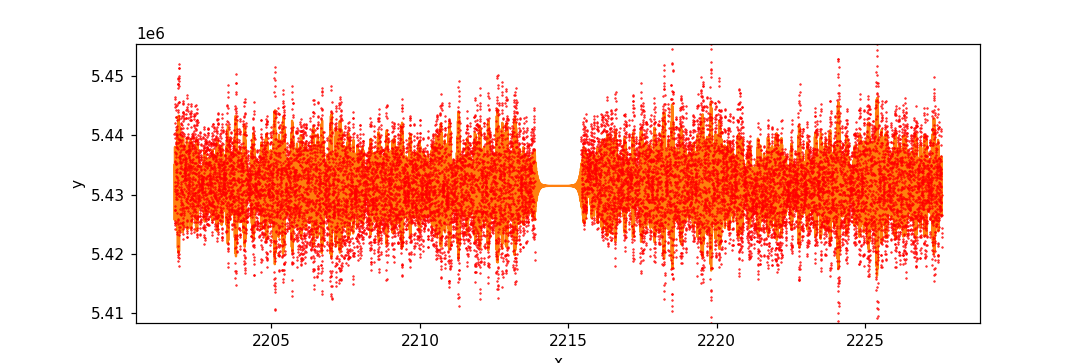

array([5434974.78483739, 5432249.20634079, 5429164.21734435, ...,
       5426759.97705579, 5428444.31413803, 5430971.7472609 ])

In [11]:
color = "#ff7f0e"
#plt.scatter(time,flux,c="r",s=1)
plt.figure(figsize=(9,3))
plt.errorbar(time,flux,yerr=0,fmt=".r",capsize=0,markersize=1)
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3, edgecolor="none",interpolate=True)
plt.xlabel("x")
plt.ylabel("y")
plt.ylim(np.nanmin(flux),np.nanmax(flux))
plt.show()
pred_mean

In [12]:
### Minimize ###
from scipy.optimize import minimize

def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)
# extract our initial guess at parameters
# from the celerite kernel and put it in a 
# vector:
p0 = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()

# run optimization:
results = minimize(neg_log_like, p0, method='L-BFGS-B',bounds=bounds,args=(flux, gp))
print(results)
print("Final log-likelihood: {0}".format(-results.fun))
print(np.exp(results.x))
print("Parameters: {0}".format(gp.get_parameter_dict()))
gp.set_parameter_vector(results.x)

      fun: 143604.81020001002
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-6.23404048, 11.83361746, 14.8662366 ])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 120
      nit: 20
   status: 0
  success: True
        x: array([9.16212656, 2.71332657, 5.72356148])
Final log-likelihood: -143604.81020001002
[9529.30017776   15.07935468  305.99277132]
Parameters: OrderedDict([('kernel:log_S0', 9.162126560348781), ('kernel:log_Q', 2.7133265684664045), ('kernel:log_omega0', 5.723561488521596)])


In [13]:
### Prédiction avec les nouveaux paramètres calculés ###
pred_mean, pred_var = gp.predict(flux, x, return_var=True)
pred_std = np.sqrt(pred_var)

<IPython.core.display.Javascript object>


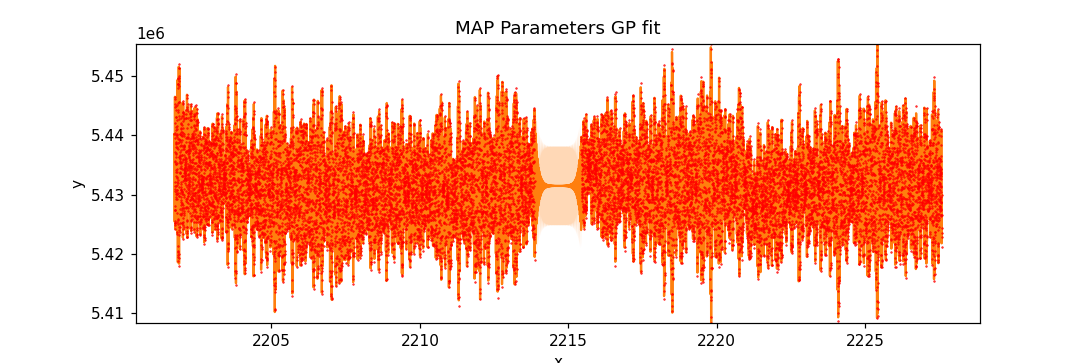

In [14]:
### Plot du posterior du minimize ###
color = "#ff7f0e"
plt.figure(figsize=(9,3))
plt.errorbar(time,flux,yerr=0,fmt=".r",capsize=0,markersize=1)
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3, edgecolor="none",interpolate=True)
plt.xlabel("x")
plt.ylabel("y")
plt.ylim(np.min(flux),np.max(flux))
plt.title("MAP Parameters GP fit")
plt.show()
# plt.scatter(x,flux - pred_mean,c='k',s=1)
# plt.axhline(y=0,color='k')
# plt.title("Residuals")
# plt.show()

In [15]:
### Définition de la likelihood ###
def log_likelihood(params,time,flux):
    gp.set_parameter_vector(params)
    ll = gp.log_likelihood(flux)
    return ll if np.isfinite(ll) else -np.inf

In [16]:
### Définition du prior (uniforme) ###
def log_prior(params):
    if ((-20 < params[0] < 10) and (-10 < params[1] < 10) and (5 < params[2] < 7)) :
        return 0
    return -np.inf

In [17]:
### Définition du posterior ###
def log_probability(params,time,flux):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params,time,flux) if np.isfinite(lp) else -np.inf

In [18]:
### MCMC ###
initial = np.array(results.x)
ndim, nwalkers = len(initial), 128
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability,args=(time,flux))

print("Running burn-in...")
p0 = initial + 1e-4 * np.random.randn(nwalkers, ndim)
p0, lp, _ = sampler.run_mcmc(p0, 500,progress=True)

print("Running production...")
sampler.reset()
sampler.run_mcmc(p0, 5000,progress=True)
print("Finished")

Running burn-in...


100%|██████████| 500/500 [05:15<00:00,  1.59it/s]


Running production...


100%|██████████| 5000/5000 [51:22<00:00,  1.62it/s]

Finished


In [19]:
print("Final MCMC Parameters: {0}".format(gp.get_parameter_dict()))
print("Final MCMC log likelihood: {0}".format(gp.log_likelihood(flux)))

Final MCMC Parameters: OrderedDict([('kernel:log_S0', 9.183617767387414), ('kernel:log_Q', 2.705395482954918), ('kernel:log_omega0', 5.729001028375438)])
Final MCMC log likelihood: -143609.9162200354


In [20]:
w = np.exp(gp.get_parameter_vector())
print(w)
f = w[2]/(2*np.pi)
f

[9736.31284919   14.96023204  307.66176943]


48.965891405819555

In [21]:
P = 1/f
print("periode :",P*24*60,"min")

periode : 29.40822598460563 min


In [22]:
pred_mean, pred_var = gp.predict(flux, x, return_var=True)
pred_std = np.sqrt(pred_var)

<IPython.core.display.Javascript object>


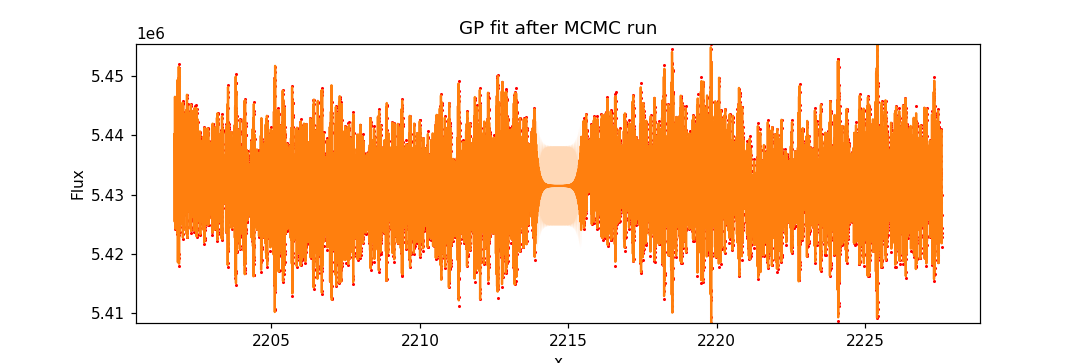

In [23]:
# Plot the data.

# Plot 24 posterior samples.
color = "#ff7f0e"
plt.figure(figsize=(9,3))
plt.scatter(time,flux,c="r",s=1)
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3, edgecolor="none",interpolate=True)
plt.xlabel("x")
plt.ylabel("Flux")
plt.ylim(np.min(flux),np.max(flux))
plt.title("GP fit after MCMC run")
plt.show()

<IPython.core.display.Javascript object>


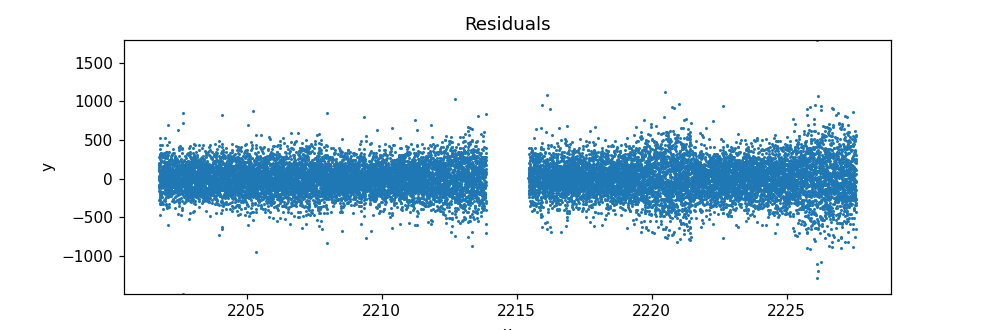

In [24]:
### Résidus ###
pred_mean, pred_var = gp.predict(flux, time, return_var=True)
pred_std = np.sqrt(pred_var)

color = "#ff7f0e"
plt.figure(figsize=(9,3))
plt.scatter(time,flux - pred_mean,s=1)
plt.xlabel("x")
plt.ylabel("y")
plt.ylim(np.min(flux - pred_mean),np.max(flux - pred_mean))
plt.title("Residuals")
plt.show()

<IPython.core.display.Javascript object>


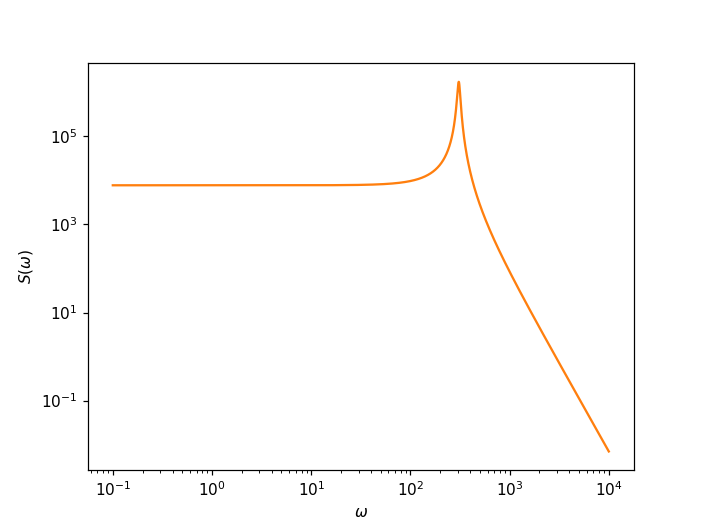

In [25]:
### PSD en fonction de omega ###
plt.figure()
omega = np.exp(np.linspace(np.log(0.1), np.log(10000), 5000))
psd = gp.kernel.get_psd(omega)
plt.plot(omega, psd, color=color)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("$\omega$")
plt.ylabel("$S(\omega)$")
plt.show()

(41728, 3)


<IPython.core.display.Javascript object>


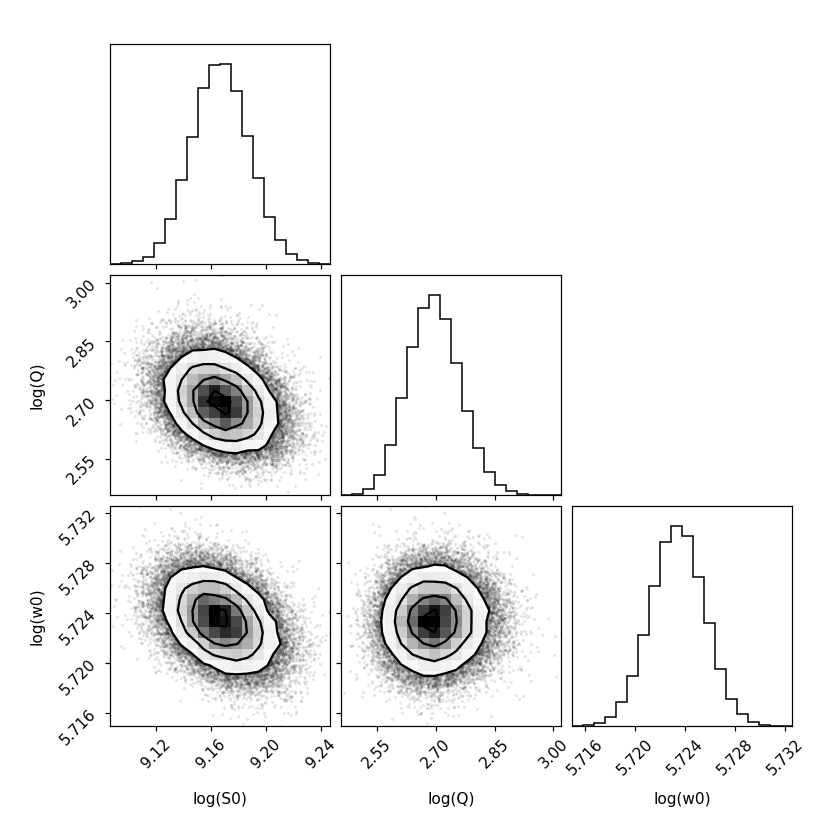

In [26]:
### Posteriors ###
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)
labels = ["log(S0)","log(Q)","log(w0)"]
fig = corner.corner(flat_samples, labels=labels, truths=[None,None,np.log(2*np.pi*24*60/30.4)])
plt.show()

In [27]:
tau = sampler.get_autocorr_time()
print(tau)

[36.37753843 37.40100808 36.90593819]


<IPython.core.display.Javascript object>


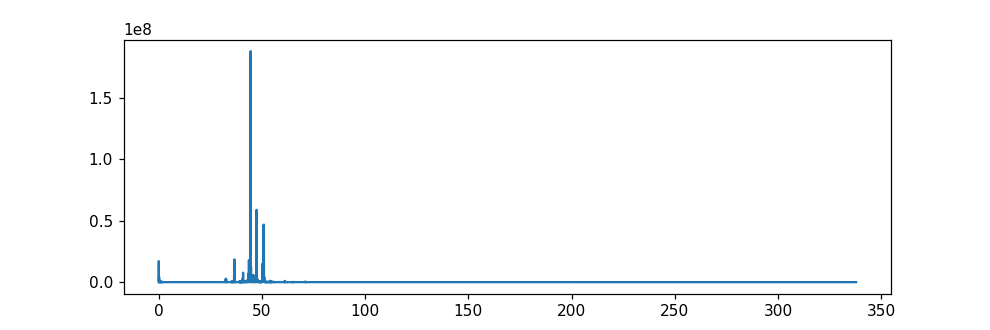

freq: 44.58433810239528 d-1
periode 32.29833751692809 min


In [28]:
### Périodogramme des résidus ###
fs = len(time)/(time[-1] - time[0])
f,pxx = signal.periodogram(pred_mean,fs)
plt.figure(figsize=(9,3))
plt.plot(f,pxx)
plt.show()
idx = np.argmax(pxx)
print("freq:", f[idx],"d-1")
print("periode",1/f[idx]*60*24,"min")

In [29]:
rv_data = np.loadtxt("rv_betapic_carine.txt",usecols=(0,1,2))
rv_time = rv_data[:,0]
rv_flux = rv_data[:,1]
rv_error = rv_data[:,2]
index = np.argwhere(rv_time>=3333)
rv_flux = np.ndarray.flatten(rv_flux[index])
rv_time = np.ndarray.flatten(rv_time[index])
rv_error = np.ndarray.flatten(rv_error[index])

<IPython.core.display.Javascript object>


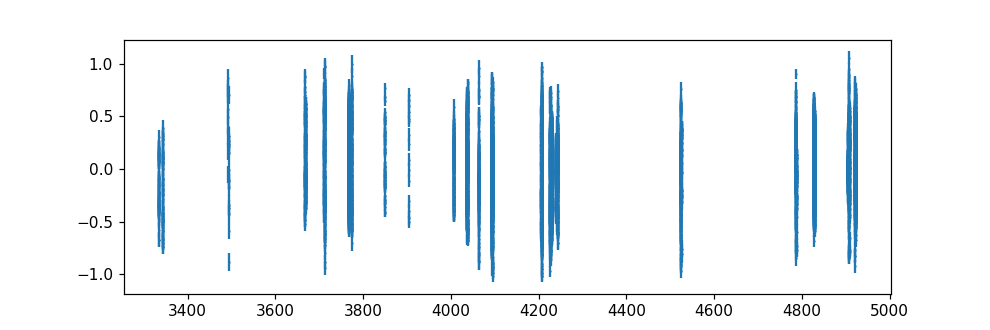

In [30]:
plt.figure(figsize=(9,3))
plt.errorbar(rv_time,rv_flux,yerr=rv_error,markersize=1,capsize=0,fmt='.')
plt.show()

<IPython.core.display.Javascript object>


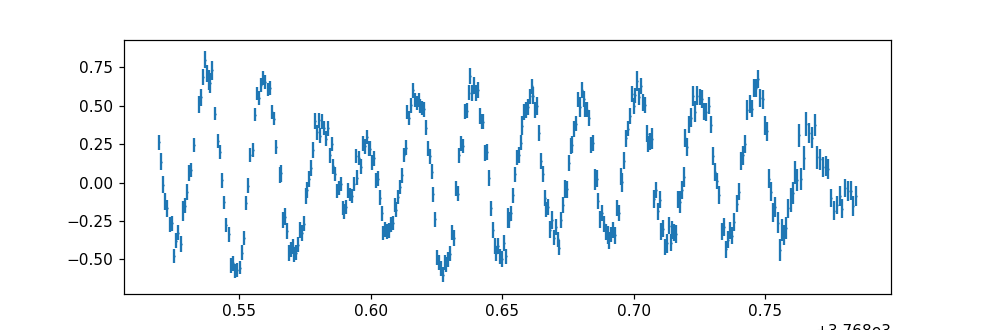

In [31]:
### Data à traiter ###
index = np.argwhere((rv_time>3768)&(rv_time<3769))
rv_flux = np.ndarray.flatten(rv_flux[index])
rv_time = np.ndarray.flatten(rv_time[index])
rv_error = np.ndarray.flatten(rv_error[index])
plt.figure(figsize=(9,3))
plt.errorbar(rv_time,rv_flux,yerr=rv_error,markersize=1,capsize=0,fmt='.')
plt.show()

In [45]:
### Récupération des hyperparamètres ###
p = gp.get_parameter_vector()

In [46]:
### GP Model ###
bounds = dict(log_S0= (None,None), log_Q = (-10,10), log_omega0 = (5,7))
#kernel = terms.SHOTerm(log_S0=7., log_Q=2.5, log_omega0=5.)
kernel = terms.SHOTerm(log_S0=p[0], log_Q=p[1], log_omega0=p[2],bounds=bounds)


gp = celerite.GP(kernel,fit_mean=True)
gp.compute(rv_time,yerr=rv_error)


print("Initial log likelihood: {0}".format(gp.log_likelihood(rv_flux)))
print("parameter_dict:\n{0}\n".format(gp.get_parameter_dict()))

Initial log likelihood: 391.5814312211003
parameter_dict:
OrderedDict([('kernel:log_S0', -11.112943855563735), ('kernel:log_Q', 3.01375740952754), ('kernel:log_omega0', 5.647212422723664), ('mean:value', 0.0)])



In [47]:
### Définition de la likelihood ###
def log_likelihood(params,time,flux):
    gp.set_parameter_vector(params)
    ll = gp.log_likelihood(flux)
    return ll if np.isfinite(ll) else -np.inf

In [48]:
### Définition du prior (uniforme) ###
def log_prior(params):
    if ((-20 < params[0] < 10) and (-10 < params[1] < 10) and (5 < params[2] < 7) and (-10 < params[3] < 10)) :
        return 0
    return -np.inf

In [49]:
### Définition du posterior ###
def log_probability(params,time,flux):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params,time,flux) if np.isfinite(lp) else -np.inf

In [50]:
### MCMC ###
initial = gp.get_parameter_vector()
ndim, nwalkers = len(initial), 128
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability,args=(rv_time,rv_flux))

print("Running burn-in...")
p0 = initial + 1e-4 * np.random.randn(nwalkers, ndim)
p0, lp, _ = sampler.run_mcmc(p0, 500,progress=True)

print("Running production...")
sampler.reset()
sampler.run_mcmc(p0, 15000,progress=True)
print("Finished")

  0%|          | 0/500 [00:00<?, ?it/s]

Running burn-in...


  0%|          | 0/15000 [00:00<?, ?it/s]

Running production...


100%|██████████| 15000/15000 [07:10<00:00, 34.85it/s]

Finished


In [51]:
print("Final MCMC Parameters: {0}".format(gp.get_parameter_dict()))
print("Final MCMC log likelihood: {0}".format(gp.log_likelihood(rv_flux)))

Final MCMC Parameters: OrderedDict([('kernel:log_S0', -11.292795120415132), ('kernel:log_Q', 7.469814786659529), ('kernel:log_omega0', 5.625699348665852), ('mean:value', 0.071280691335276)])
Final MCMC log likelihood: 405.52305475563423


In [52]:
w = np.exp(gp.get_parameter_vector())
print(w)
f = w[2]/(2*np.pi)
f

[1.24623916e-05 1.75428174e+03 2.77466262e+02 1.07388261e+00]


44.16012719368653

In [53]:
P = 1/f
print("periode :",P*24*60,"min")

periode : 32.608601729885265 min


In [54]:
x = np.linspace(np.min(rv_time),np.max(rv_time)+0.25,15000)
pred_mean, pred_var = gp.predict(rv_flux, x, return_var=True)
pred_std = np.sqrt(pred_var)

<IPython.core.display.Javascript object>


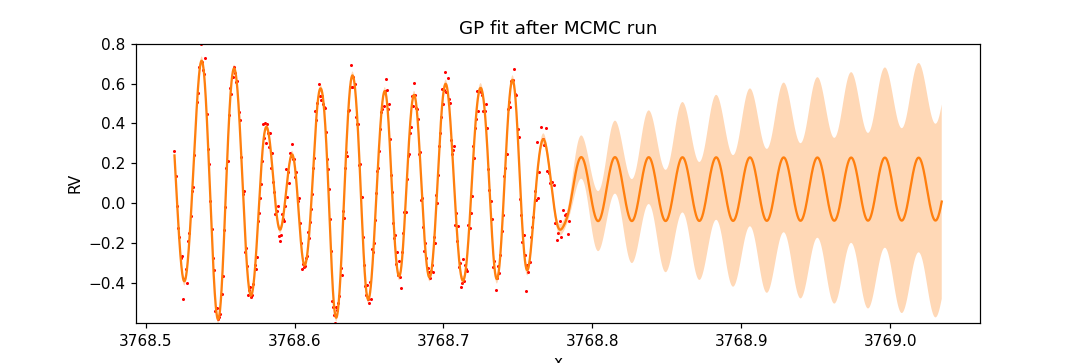

In [55]:
# Plot the data.

# Plot 24 posterior samples.
color = "#ff7f0e"
plt.figure(figsize=(9,3))
plt.scatter(rv_time,rv_flux,c="r",s=1)
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3, edgecolor="none",interpolate=True)
plt.xlabel("x")
plt.ylabel("RV")
plt.ylim(np.min(rv_flux),np.max(rv_flux))
plt.title("GP fit after MCMC run")
plt.show()

<IPython.core.display.Javascript object>


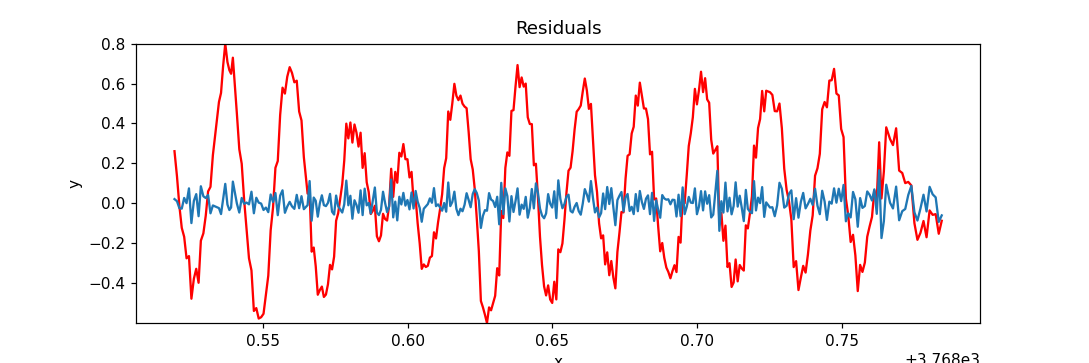

In [56]:
### Résidus ###
pred_mean, pred_var = gp.predict(rv_flux, rv_time, return_var=True)
pred_std = np.sqrt(pred_var)
res = rv_flux - pred_mean
color = "#ff7f0e"
plt.figure(figsize=(9,3))
plt.plot(rv_time,rv_flux,c="r")
plt.plot(rv_time,res)
plt.xlabel("x")
plt.ylabel("y")
plt.ylim(np.min(rv_flux),np.max(rv_flux))
plt.title("Residuals")
plt.show()

(127104, 4)


<IPython.core.display.Javascript object>


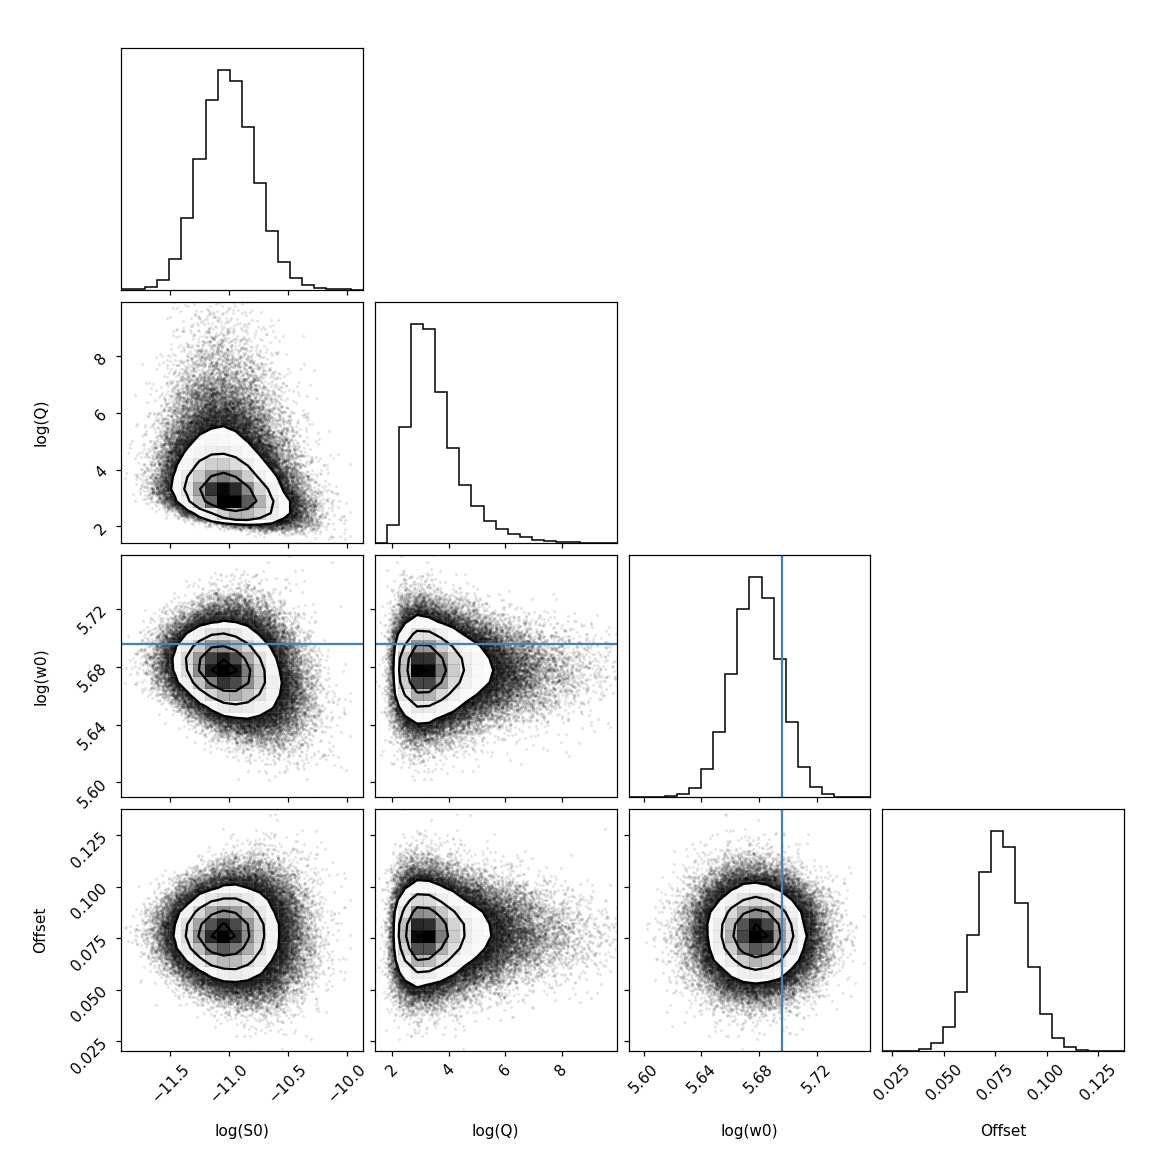

In [57]:
### Posteriors ###
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)
labels = ["log(S0)","log(Q)","log(w0)","Offset"]
fig = corner.corner(flat_samples, labels=labels, truths=[None,None,np.log(2*np.pi*24*60/30.4),None])
plt.show()

In [58]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>